In [1]:
import os
ionq_token='WAPGr9HuaoeCAZzrx8njY21gFsJRg7Mc'
from qiskit_ionq import IonQProvider
provider = IonQProvider(ionq_token)

# show supported backends
print(provider.backends()) 

# create backends for simulator and hardware
backend_simq = provider.get_backend("ionq_simulator")
backend_qpu = provider.get_backend("ionq_qpu")

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [2]:
# Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from qiskit_experiments.framework import ParallelExperiment, BatchExperiment
import qiskit.circuit.library as circuits
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit import Aer, QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, assemble

In [3]:
from sklearn.preprocessing import normalize
from qiskit.visualization import array_to_latex

In [4]:
backend = backend_qpu

In [5]:
backend_aer = Aer.get_backend('qasm_simulator')  

In [6]:
# gen_calib_circs: returns a list of all 2^n calibration circuits
# params: qn: # of qubits

def gen_calib_circs(qn):
    qc = QuantumCircuit(qn)
    circ_list = []
    build_circ(qn, qc, circ_list)
    return circ_list

# build_circ: builds the circuits for gen_calib_circs
# IMPORTANT NOTE: THIS DOES NOT MEASURE ALL BY DEFAULT
def build_circ(i, qc, circ_list):
    if i > 0:
        build_circ(i-1, qc.copy(), circ_list)
        qc.x(i - 1)
        build_circ(i-1, qc, circ_list)
    else:
        circ_list.append(qc)
        
for i in range(8):
        print(gen_calib_circs(3)[i].draw())
    
        

     
q_0: 
     
q_1: 
     
q_2: 
     
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
          
q_2: ─────
          
          
q_0: ─────
     ┌───┐
q_1: ┤ X ├
     └───┘
q_2: ─────
          
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
          
          
q_0: ─────
          
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
          
q_0: ─────
     ┌───┐
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └───┘
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     ├───┤
q_2: ┤ X ├
     └───┘


In [ ]:
qn = 3
qcs = gen_calib_circs(qn)
SHOTS = 4096
cal_results = [0] * (2 ** qn)
for i in range(2**(qn)):
    # In IonQ, circuits without any gates can only have a maximum of
    # 1000 shots. Anything more returns an error. This reduces accuracy
    # for the calib matrix entry A_00, but that will always be 
    # very nearly 1.0, because any noise is entirely background noise
    # rather than noise introduced by gates and dephasing.
    if i == 0:
        cal_results[i] = backend_qpu.run(qcs[i], shots=1000).result()
    else:
        cal_results[i] = backend_qpu.run(qcs[i], shots=4096).result()

In [ ]:
for i in range(2 ** (qn)):
    print(cal_results[i].get_counts())

In [7]:
#bin_form: dictionary[str] - Returns a dictionary of keys of correct form for qiskit histograms.
# For instance, for a qn=3 qubit key, we want 000 rather than 00, and 010 rather than 10. 
def bin_form(count_dict, qn):
    ret_dict = {}
    for key in count_dict:
        old_key = key
        while len(key) < qn:
            key = '0' + key
        ret_dict[key] = count_dict[old_key]
        
    return ret_dict

In [ ]:
dict_test = {
    "10": 31,
    "0": 2,
    "001": 3
}

print(bin_form(dict_test, qn))

In [8]:
qn = 3
calib_counts_mat = [[0] * (2 ** qn)] * (2 ** qn)

print(calib_counts_mat)

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0]]


In [9]:
def result_dict_to_arr(counts_dict):
    ret_arr = [0] * (2 ** qn)
    for (bit_str, counts) in counts_dict.items():
        arr_pos = 0
        bit_length = len(bit_str)
        for i in range(bit_length):
            arr_pos += (int(bit_str[i]) * (2 ** (bit_length - (i+1))))
            
        ret_arr[arr_pos] = counts
    return ret_arr

#for i in range(len(calib_counts_mat)):
 #   calib_counts_mat[i] = result_dict_to_arr(cal_results[i].get_counts())

In [ ]:
array_to_latex(calib_counts_mat)

In [ ]:
counts_mat = np.array(calib_list).astype(np.float64)
normed_mat = normalize(calib_counts_mat, axis=1, norm='l1')

print(normed_mat)

In [ ]:
array_to_latex(normed_mat)

In [ ]:
id_mat = np.identity(2**qn)

array_to_latex(id_mat)

In [ ]:
calib_mat = np.linalg.lstsq(normed_mat, id_mat, rcond=0)[0]

In [ ]:
qn = 3

In [ ]:
array_to_latex(calib_mat)

In [ ]:
qc = QuantumCircuit(qn)
qc.h(0)
qc.cx(0, range(1, 3))
qc.measure_all()

In [ ]:
len(qc)

In [ ]:
qc.draw(output = 'mpl')

In [ ]:
noisy_ghz = backend_qpu.run(qc, shots=4096).result()

In [ ]:
noisy_counts = noisy_ghz.get_counts()
print(noisy_counts)

In [ ]:
noisy_mat = result_dict_to_arr(noisy_counts)
print(result_dict_to_arr(noisy_counts))            

In [ ]:
mitigated_mat = np.dot(calib_mat, noisy_mat)

In [ ]:
array_to_latex(mitigated_mat)

In [10]:
def count_arr_to_dict(arr):
    ret_dict = {}
    get_bin = lambda x: format(x, 'b')
    for i in range(len(arr)):
        if get_bin(i) == '0':
            ret_dict['000'] = arr[i]
        elif get_bin(i) == '1':
            ret_dict['001'] = arr[i]
        else:
            ret_dict[get_bin(i)] = arr[i]
    return ret_dict

#mitigated_counts = count_arr_to_dict(mitigated_mat)

In [11]:
from qiskit.visualization import plot_histogram 

In [ ]:

plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

In [ ]:
calibs_1 = gen_calib_circs(qn)
calibs_2 = gen_calib_circs(qn)

In [ ]:
for circ in calibs_1:
    circ.cu(1.45, 6.05, 2.55, 0, 1, 0)
    circ.i(2)
    circ.compose(circ.inverse(), inplace = True)
    circ.measure_all()


In [ ]:

calibs_1[0].draw()

In [ ]:
for circ in calibs_2:
    circ.cnot(1, 0)
    circ.ry(4.75, 2)
    circ.s(0)
    circ.x(1)
    circ.p(1.17, 2)
    
    circ.compose(circ.inverse(), inplace = True)
    circ.measure_all()
    

calibs_2[0].draw()


In [12]:
# create bankend for Qiskit's AER (QSAM simulator)
from qiskit import Aer
aer_sim = Aer.get_backend('qasm_simulator') 
# define the backend to obtain and display state vectors
from qiskit import BasicAer, execute
from qiskit.tools.visualization import plot_bloch_multivector, plot_state_qsphere, array_to_latex

backend_v = BasicAer.get_backend('statevector_simulator')

In [ ]:
# Define an F_gate
def F_gate(circ,q,i,j,n,k) :
    theta = np.arccos(np.sqrt(1/(n-k+1)))
    circ.ry(-theta,q[j])       
    circ.cz(q[i],q[j])
    circ.ry(theta,q[j])
    circ.barrier(q[i])
# Define the cxrv gate which uses reverse CNOT instead of CNOT
def  cxrv(circ,q,i,j) :
    circ.h(q[i])
    circ.h(q[j])
    circ.cx(q[j],q[i])
    circ.h(q[i])
    circ.h(q[j])
    circ.barrier(q[i],q[j])

In [ ]:
def F_gates(circ, q, n, k) :
  if(n > k):
    theta = np.arccos(np.sqrt( 1 / (n - k + 1)))
    
    circ.ry(-theta, q[n - k - 1])
    circ.cz(q[n - k], q[n - k - 1])
    circ.ry(theta, q[n - k - 1])
    circ.barrier(q[n - k])

    F_gates(circ, q, n, k + 1)

def cx_all(circ, q, n):
  if(n > 1):
    circ.cx(q[n - 2], q[n - 1])
    cx_all(circ, q, n - 1)

def cxrv_all(circ, q, n):   
  if(n > 1):
    circ.cx(q[n-1], q[n-2]) 
    cxrv_all(circ, q, n - 1)

In [ ]:
#Generates an n-qubit W-state. n: number of qubits
#NOTE AGAIN: Does not measure!
def gen_w_state(n):
    q = QuantumRegister(n)
    W_states = QuantumCircuit(n)
    
    W_states.x(q[n-1])
    F_gates(W_states, q, n, 1)
    cx_all(W_states, q, n)
    
    return W_states


In [ ]:
w_state_circ = gen_w_state(qn)
w_state_circ.draw(output = 'mpl')

In [ ]:
w_state_circ.measure_all()

In [ ]:
print(w_state_circ.num_qubits)

In [ ]:
shots = 1024
result = execute(w_state_circ, backend=backend_aer, shots=shots)
plot_histogram(result.result().get_counts(w_state_circ))

In [ ]:
noisy_w = backend_qpu.run(w_state_circ, shots=4096).result()

In [ ]:
noisy_w_counts = noisy_w.get_counts()
print(noisy_w_counts)

In [ ]:
noisy_w_mat = result_dict_to_arr(noisy_w_counts)
mitigated_w_mat = np.dot(calib_mat, noisy_w_mat)
array_to_latex(mitigated_w_mat)

In [ ]:
mitigated_w_counts = count_arr_to_dict(mitigated_w_mat)
print(mitigated_w_counts)

In [ ]:
mitigated_w_counts['010'] = mitigated_w_counts.pop('10')
mitigated_w_counts['011'] = mitigated_w_counts.pop('11')

In [ ]:
from qiskit.visualization import plot_histogram 
plot_histogram([noisy_w_counts, mitigated_w_counts], legend=['noisy', 'mitigated'])

In [13]:
from qiskit.circuit.random import random_circuit

In [ ]:
qc_rand = random_circuit(3, 3)
qc_rand.draw(output = 'mpl')

In [ ]:
qc_rand.data

In [14]:
def gen_first_half_circ(qc, qn):  
    temp_circ = QuantumCircuit(qn)
    ret_circ = QuantumCircuit(qn)
    req_depth = (qc.depth() // 2)
    for i in qc.data:
        temp_circ.data.append(i)
        if(temp_circ.depth() <= req_depth):
            ret_circ.data.append(i)
        else:
            return ret_circ.compose(ret_circ.inverse())
        
def gen_second_half_circ(qc, qn):
    temp_circ = QuantumCircuit(qn)
    ret_circ = QuantumCircuit(qn)
    req_depth = (qc.depth() // 2)
    for i in qc.data:
        temp_circ.data.append(i)
        if(temp_circ.depth() > req_depth):
            ret_circ.data.append(i)
    return ret_circ.compose(ret_circ.inverse())

In [ ]:
calib_1 = gen_calib_circs(qn)
calib_2 = gen_calib_circs(qn)

In [ ]:
first_half = gen_first_half_circ(qc_rand, qn)
second_half = gen_second_half_circ(qc_rand, qn)

for circ in calib_1:
    circ.compose(first_half, inplace = True)
    
for circ in calib_2:
    circ.compose(second_half, inplace = True)

In [ ]:
calib_1[1].draw()

In [15]:
# general-error-mitigation-helper: 
# Input: qc: (QuantumCircuit) - Circuit of interest (mitigated circuit)
#       qn: (int) - Number of qubits
# Output: calib_1: List(QuantumCircuit) - A list of 2^qn calibration circuits composed with the gates of the circuit of interest and their inverses up to depth D / 2
#         calib_2: List(QuantumCircuit) - A list of 2^qn calibration circuits composed with the gates of the circuit of interest and their inverses from depth D / 2 to D

def general_error_mitigation_helper(circ):
    qn = circ.num_qubits
    calib_1 = gen_calib_circs(qn)
    calib_2 = gen_calib_circs(qn)
    first_half = gen_first_half_circ(circ, qn)
    second_half = gen_second_half_circ(circ, qn)

    for circ1 in calib_1:
        circ1.compose(first_half, inplace = True)
        circ1.measure_all()

    for circ2 in calib_2:
        circ2.compose(second_half, inplace = True)
        circ2.measure_all()
        
    return calib_1, calib_2



In [ ]:
first_half, second_half = general_error_mitigation_helper(qc_rand, qn)

In [ ]:
first_half[0].draw(output = 'mpl')

In [ ]:
second_half[2].draw(output = 'mpl')

In [ ]:
calib_results_1 = [0] * 2 ** qn
calib_results_2 = [0] * 2 ** qn

In [16]:
import time

In [ ]:
start_time = time.time()
print("Start time: ", time.ctime(start_time))
for i in range(2**(qn)):
    # In IonQ, circuits without any gates can only have a maximum of
    # 1000 shots. Anything more returns an error. This reduces accuracy
    # for the calib matrix entry A_00, but that will always be 
    # very nearly 1.0, because any noise is entirely background noise
    # rather than noise introduced by gates and dephasing.
    if i == 0:
        calib_results_1[i] = backend_qpu.run(first_half[i], shots=1000).result()
        calib_results_2[i] = backend_qpu.run(second_half[i], shots=1000).result()
    else:
        calib_results_1[i] = backend_qpu.run(first_half[i], shots=4096).result()
        calib_results_2[i] = backend_qpu.run(second_half[i], shots=4096).result()
        
end_time = time.time()
print("End time: ", time.ctime(end_time))

In [ ]:
calib_counts_mat_1 = [[0] * (2 ** qn)] * (2 ** qn)
calib_counts_mat_2 = [[0] * (2 ** qn)] * (2 ** qn)
for i in range(len(calib_counts_mat_1)):
    calib_counts_mat_1[i] = result_dict_to_arr(calib_results_1[i].get_counts())
    calib_counts_mat_2[i] = result_dict_to_arr(calib_results_2[i].get_counts())
    print(calib_counts_mat_1[i])
    print(calib_counts_mat_2[i])
    
avg_calib_counts_mat = [[0] * 2 ** qn] * 2 ** qn

for i in range(len(avg_calib_counts_mat)):
    for j in range(len(avg_calib_counts_mat[i])):
        avg_calib_counts_mat[i][j] = (calib_counts_mat_1[i][j] + calib_counts_mat_2[i][j]) / 2

In [ ]:
calib_arr_1 = np.array(calib_counts_mat_1)

In [ ]:
calib_arr_2 = np.array(calib_counts_mat_2)

In [ ]:
avg_calib_counts_mat = ((calib_arr_1 + calib_arr_2) / 2)

In [ ]:
array_to_latex(avg_calib_counts_mat)

In [ ]:
normed_mat = normalize(avg_calib_counts_mat, axis=1, norm='l1')
final_calib_mat = np.linalg.lstsq(normed_mat, id_mat, rcond=0)[0]

In [ ]:
noisy_gem = backend_qpu.run(qc_rand, shots=4096).result()

In [ ]:
noisy_gem_counts_1 = noisy_gem.get_counts()

In [ ]:
noisy_gem_counts = bin_form(noisy_gem_counts_1, qn)

In [ ]:
noisy_gem_mat = result_dict_to_arr(noisy_gem.get_counts())

In [ ]:
array_to_latex(noisy_gem_mat)

In [ ]:
mitigated_gem_mat = np.dot(final_calib_mat, noisy_gem_mat)

In [ ]:
qc_rand.measure_all()

In [ ]:
ideal_gem = execute(qc_rand, backend=backend_aer, shots=4096).result()

In [ ]:
print(ideal_gem.get_counts())

In [ ]:
ideal_gem_counts = ideal_gem.get_counts()

In [ ]:
mitigated_gem_counts_1 = count_arr_to_dict(mitigated_gem_mat)

In [ ]:
mitigated_gem_counts = bin_form(mitigated_gem_counts_1, qn)

In [ ]:
plot_histogram([ideal_gem_counts, noisy_gem_counts, mitigated_gem_counts], legend=['ideal', 'noisy', 'mitigated'])

In [17]:
from qiskit.circuit import Reset
from qiskit.extensions import (IGate, UGate, XGate,
                               YGate, ZGate, HGate, SGate, SdgGate, TGate,
                               TdgGate, RXGate, RYGate, RZGate, CXGate,
                               CYGate, CZGate, CHGate, CRZGate, CUGate,
                               SwapGate, RZZGate,
                               CCXGate, CSwapGate)
from qiskit.circuit.exceptions import CircuitError

In [18]:
def modified_random_circuit(n_qubits, depth, max_operands=3, measure=False,
                   conditional=False, reset=False, seed=None):
#   FROM QISKIT:
#   Generate random circuit of arbitrary size and form.
#
#   This function will generate a random circuit by randomly selecting gates
#    from the set of standard gates in :mod:`qiskit.extensions`. For example:
#    .. jupyter-execute::
#        from qiskit.circuit.random import random_circuit
#        circ = random_circuit(2, 2, measure=True)
#        circ.draw(output='mpl')
#    Args:
#        n_qubits (int): number of quantum wires
#        depth (int): layers of operations (i.e. critical path length)
#        max_operands (int): maximum operands of each gate (between 1 and 3)
#        measure (bool): if True, measure all qubits at the end
#        conditional (bool): if True, insert middle measurements and conditionals
#        reset (bool): if True, insert middle resets
#        seed (int): sets random seed (optional)
#   Returns:
#        QuantumCircuit: constructed circuit
#    Raises:
#        CircuitError: when invalid options given
            
    if max_operands < 1 or max_operands > 3:
        raise CircuitError("max_operands must be between 1 and 3")

    one_q_ops = [IGate, XGate, YGate, ZGate,
                 HGate, SGate, SdgGate, TGate, TdgGate, RXGate, RYGate, RZGate]
    one_param = [RXGate, RYGate, RZGate, RZZGate, CRZGate]
    two_param = []
    three_param = [UGate]
    four_param = [CUGate]
    two_q_ops = [CXGate, CYGate, CZGate, CHGate, CRZGate,
                  SwapGate, RZZGate]
    three_q_ops = [CCXGate]


    qr = QuantumRegister(n_qubits, 'q')
    qc = QuantumCircuit(n_qubits)

    if measure or conditional:
        cr = ClassicalRegister(n_qubits, 'c')
        qc.add_register(cr)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.RandomState(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1, 2, or 3 qubits for the operation
        remaining_qubits = list(range(n_qubits))
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            rng.shuffle(remaining_qubits)
            operands = remaining_qubits[:num_operands]
            remaining_qubits = [q for q in remaining_qubits if q not in operands]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = rng.choice(two_q_ops)
            elif num_operands == 3:
                operation = rng.choice(three_q_ops)
            if operation in one_param:
                num_angles = 1
            elif operation in two_param:
                num_angles = 2
            elif operation in three_param:
                num_angles = 3
            elif operation in four_param:
                num_angles = 4
            else:
                num_angles = 0
            angles = [rng.uniform(0, 2 * np.pi) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            # with some low probability, condition on classical bit values
            if conditional and rng.choice(range(10)) == 0:
                value = rng.randint(0, np.power(2, n_qubits))
                op.condition = (cr, value)

            qc.append(op, register_operands)

    if measure:
        qc.measure(qr, cr)

    return qc

In [19]:
from qiskit_ionq import GPIGate, GPI2Gate, MSGate
backend_simq2 = provider.get_backend("ionq_simulator", gateset="native")
backend_qpu2 = provider.get_backend("ionq_qpu", gateset="native")

In [20]:
def gen_native_calib_circs(qn):
    qc = QuantumCircuit(qn)
    circ_list = []
    build_native_circ(qn, qc, circ_list)
    return circ_list

# build_circ: builds the circuits for gen_calib_circs
# IMPORTANT NOTE: THIS DOES NOT MEASURE ALL BY DEFAULT
def build_native_circ(i, qc, circ_list):
    if i > 0:
        build_native_circ(i-1, qc.copy(), circ_list)
        qc.append(GPIGate(0.5), [i - 1])
        build_native_circ(i-1, qc, circ_list)
    else:
        circ_list.append(qc)
        
for i in range(8):
        print(gen_native_calib_circs(3)[i].draw())

     
q_0: 
     
q_1: 
     
q_2: 
     
     ┌──────────┐
q_0: ┤ Gpi(0.5) ├
     └──────────┘
q_1: ────────────
                 
q_2: ────────────
                 
                 
q_0: ────────────
     ┌──────────┐
q_1: ┤ Gpi(0.5) ├
     └──────────┘
q_2: ────────────
                 
     ┌──────────┐
q_0: ┤ Gpi(0.5) ├
     ├──────────┤
q_1: ┤ Gpi(0.5) ├
     └──────────┘
q_2: ────────────
                 
                 
q_0: ────────────
                 
q_1: ────────────
     ┌──────────┐
q_2: ┤ Gpi(0.5) ├
     └──────────┘
     ┌──────────┐
q_0: ┤ Gpi(0.5) ├
     └──────────┘
q_1: ────────────
     ┌──────────┐
q_2: ┤ Gpi(0.5) ├
     └──────────┘
                 
q_0: ────────────
     ┌──────────┐
q_1: ┤ Gpi(0.5) ├
     ├──────────┤
q_2: ┤ Gpi(0.5) ├
     └──────────┘
     ┌──────────┐
q_0: ┤ Gpi(0.5) ├
     ├──────────┤
q_1: ┤ Gpi(0.5) ├
     ├──────────┤
q_2: ┤ Gpi(0.5) ├
     └──────────┘


In [21]:
def simple_error_mitigation(qc, shots, backend, backend_sim = backend_simq, gates= 'qis'):
    circ = qc.copy()
    # Removes the final measurements if they exist, does nothing otherwise. Ensures that all experiments are being measured
    # as expected.
    circ.remove_final_measurements(inplace=True)
    circ.measure_all()
    start_time = time.time()
    print("Start time: ", time.ctime(start_time))
    qn = circ.num_qubits
    id_mat = np.identity(2**qn)
    if(gates == 'qis'):
        qcs = gen_calib_circs(qn)
        print('generated qis calib')
    elif(gates == 'native'):
        qcs = gen_native_calib_circs(qn)
        print('generated native calib')
    else:
        print('Invalid basis gate option. The options are: ''qis'' (default), ''native''')
    cal_run = [0] * (2 ** qn)
    cal_results = [0] * (2 ** qn)
    for i in range(2**(qn)):
        # In IonQ, circuits without any gates can only have a maximum of
        # 1000 shots. Anything more returns an error. This reduces accuracy
        # for the calib matrix entry A_00, but that will always be 
        # very nearly 1.0, because any noise is entirely background noise
        # rather than noise introduced by gates and dephasing.
        if(i == 0):
            if(gates == 'qis'):
                # possibly switch backend.run with execute
                #Call .result() afterward
                cal_run[i] = backend.run(qcs[i], shots=1000)
                print('Done with running calibration circuit ', i)
        else:
            print('i=', i)
            cal_run[i] = backend.run(qcs[i], shots=shots)
            print('Done with running calibration circuit ', i)
    noisy_run = backend.run(circ, shots = shots) 
    ideal_run = backend_sim.run(circ, shots = shots)
    
    for i in range(1, 2**(qn)):
        #if(i == 0):
            #cal_results[i] = backend_sim.run(qcs[i], shots = 1000).result()
        start_time = time.time()
        print("Start time for results of calib circ", i, ": ",time.ctime(start_time))
        cal_results[i] = cal_run[i].result()
        end_time = time.time()
        print("End time for results of calib circ", i, ": ", time.ctime(end_time))
        
    
    noisy_results = noisy_run.result()
    noisy_counts = noisy_results.get_counts()
    
    ideal_results = ideal_run.result()
    ideal_counts = ideal_results.get_counts()
        
    calib_counts_mat = [[0] * (2 ** qn)] * (2 ** qn)
    
    calib_counts_mat[0] = [shots] + ([0] * ((2 ** qn) - 1))
    for i in range(1, len(calib_counts_mat)):
        calib_counts_mat[i] = result_dict_to_arr(cal_results[i].get_counts())
        
    normed_mat = normalize(calib_counts_mat, axis=1, norm='l1')
    calib_mat = np.linalg.lstsq(normed_mat, id_mat, rcond=0)[0]
        
    
    noisy_counts_formatted = bin_form(noisy_counts, qn)
    noisy_mat = result_dict_to_arr(noisy_counts_formatted)
    
    mitigated_mat = np.dot(calib_mat, noisy_mat)
    mitigated_counts = count_arr_to_dict(mitigated_mat)
    mitigated_counts_formatted = bin_form(mitigated_counts, qn)
    
    ideal_counts_formatted = bin_form(ideal_counts, qn)
    #print('Noisy Matrix:')
    #array_to_latex(noisy_mat)
    
    #print('Mitigated Matrix:')
    #array_to_latex(mitigated_mat)
    
    plot_histogram([noisy_counts_formatted, mitigated_counts_formatted], legend=['noisy', 'mitigated'])
    end_time = time.time()
    print("End time: ", time.ctime(end_time))
    
    return noisy_counts_formatted, mitigated_counts_formatted, ideal_counts_formatted

In [22]:
def general_error_mitigation(qc, shots, backend, backend_sim = "backend_simq"):
    circ = qc.copy()
    qn = circ.num_qubits
    circ.remove_final_measurements(inplace=True)
    id_mat = np.identity(2**qn)
    circ.measure_all()
    first_half, second_half = general_error_mitigation_helper(circ)
    start_time = time.time()
    calib_run_1, calib_run_2, calib_results_1, calib_results_2 = [0] * 2 ** qn
    print("Start time for calibration matrices: ", time.ctime(start_time))
    for i in range(2**(qn)):
            calib_run_1[i] = backend_qpu.run(first_half[i], shots=shots)
            calib_run_2[i] = backend_qpu.run(second_half[i], shots=shots)

    end_time = time.time()
    print("End time: ", time.ctime(end_time))

    noisy_gem_run = backend_qpu.run(qc, shots=shots)
    
    for i in range(2 ** qn):
        calib_results_1[i] = calib_run_1[i].result()
        calib_results_2[i] = calib_run_2[i].result()
        
    noisy_gem = noisy_gem_run.result()
    
    calib_counts_mat_1 = [[0] * (2 ** qn)] * (2 ** qn)
    calib_counts_mat_2 = [[0] * (2 ** qn)] * (2 ** qn)
    
    for i in range(len(calib_counts_mat_1)):
        calib_counts_mat_1[i] = result_dict_to_arr(calib_results_1[i].get_counts())
        calib_counts_mat_2[i] = result_dict_to_arr(calib_results_2[i].get_counts())
        print(calib_counts_mat_1[i])
        print(calib_counts_mat_2[i])

    avg_calib_counts_mat = [[0] * 2 ** qn] * 2 ** qn

    calib_arr_1 = np.array(calib_counts_mat_1)
    calib_arr_2 = np.array(calib_counts_mat_2)
    avg_calib_counts_mat = ((calib_arr_1 + calib_arr_2) / 2)
    
    normed_mat = normalize(avg_calib_counts_mat, axis=1, norm='l1')
    final_calib_mat = np.linalg.lstsq(normed_mat, id_mat, rcond=0)[0]
    
    
    noisy_gem_mat = result_dict_to_arr(noisy_gem.get_counts())
    
    mitigated_gem_mat = np.dot(final_calib_mat, noisy_gem_mat)
    mitigated_gem_counts = count_arr_to_dict(mitigated_gem_mat)
    mitigated_gem_formatted = bin_form(mitigated_gem_counts, qn)
    
    
    return noisy_gem, mitigated_gem_mat, ideal_gem_mat

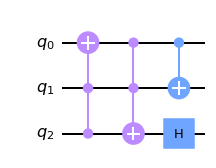

In [23]:
rand_circ_test = modified_random_circuit(3, 3)
rand_circ_test.draw(output = 'mpl')

In [24]:
rand_circ_test.measure_all()

In [25]:
rand_circ_test_run = backend_qpu.run(rand_circ_test, shots = 4096).result()

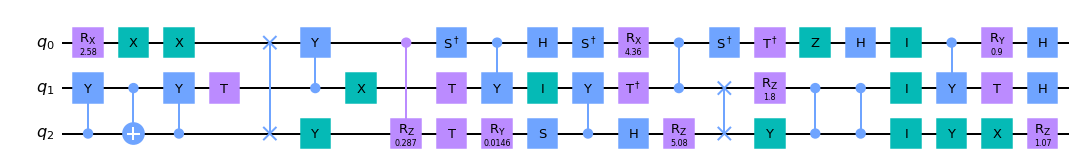

In [26]:
rand_circ_2 = modified_random_circuit(3, 20, max_operands = 2)
rand_circ_2.draw(output = 'mpl')

In [ ]:
test = simple_error_mitigation(rand_circ_2, 4096, backend_qpu)

In [ ]:
start_time = time.time()
print("Start time: ", time.ctime(start_time))
test_rand = backend_qpu.run(rand_circ_2, shots=4096).result()
print(test_rand.get_counts())
end_time = time.time()
print("End time: ", time.ctime(end_time))

In [ ]:
start_time = time.time()
print("Start time: ", time.ctime(start_time))
test_rand_sim = backend_simq.run(rand_circ_2, shots=4096).result()
print(test_rand_sim.get_counts())
end_time = time.time()
print("End time: ", time.ctime(end_time))

In [ ]:
start_time = time.time()
print("Start time: ", time.ctime(start_time))
test_rand_sim = backend_simq.run(rand_circ_2, shots=4096).result()
print(test_rand_sim.get_counts())
end_time = time.time()
print("End time: ", time.ctime(end_time))

In [ ]:
rand_circ_2.draw(output = 'mpl')

In [ ]:
sem_noisy, sem_mit = simple_error_mitigation(rand_circ_2, 4096, backend_qpu)

In [27]:
def ionq_native_random_circuit(n_qubits, depth, max_operands=2, measure=False,
                   conditional=False, reset=False, seed=None):
#   FROM QISKIT:
#   Generate random circuit of arbitrary size and form.
#   
#   This function will generate a random circuit by randomly selecting gates
#    from the set of native gates provided by IonQ (GPIGate, GPI2Gate, MSGate)
#   These three gates form a universal basis.
#    Args:
#        n_qubits (int): number of quantum wires
#        depth (int): layers of operations (i.e. critical path length)
#        max_operands (int): maximum operands of each gate (between 1 and 3)
#        measure (bool): if True, measure all qubits at the end
#        conditional (bool): if True, insert middle measurements and conditionals
#        reset (bool): if True, insert middle resets
#        seed (int): sets random seed (optional)
#   Returns:
#        QuantumCircuit: constructed circuit
#    Raises:
#        CircuitError: when invalid options given
            
    if max_operands < 1 or max_operands > 2:
        raise CircuitError("max_operands must be between 1 and 2")

    one_q_ops = [GPIGate, GPI2Gate]
    one_param = [GPIGate, GPI2Gate]
    two_param = [MSGate]
    two_q_ops = [MSGate]


    qr = QuantumRegister(n_qubits, 'q')
    qc = QuantumCircuit(n_qubits)

    if measure or conditional:
        cr = ClassicalRegister(n_qubits, 'c')
        qc.add_register(cr)

    if reset:
        one_q_ops += [Reset]

    if seed is None:
        seed = np.random.randint(0, np.iinfo(np.int32).max)
    rng = np.random.RandomState(seed)

    # apply arbitrary random operations at every depth
    for _ in range(depth):
        # choose either 1 or 2 qubits for the operation
        remaining_qubits = list(range(n_qubits))
        while remaining_qubits:
            max_possible_operands = min(len(remaining_qubits), max_operands)
            num_operands = rng.choice(range(max_possible_operands)) + 1
            rng.shuffle(remaining_qubits)
            operands = remaining_qubits[:num_operands]
            remaining_qubits = [q for q in remaining_qubits if q not in operands]
            if num_operands == 1:
                operation = rng.choice(one_q_ops)
            elif num_operands == 2:
                operation = MSGate
            if operation in one_param:
                num_angles = 1
            elif operation in two_param:
                num_angles = 2
            else:
                num_angles = 0
            angles = [rng.uniform(-1, 1) for x in range(num_angles)]
            register_operands = [qr[i] for i in operands]
            op = operation(*angles)

            # with some low probability, condition on classical bit values
            if conditional and rng.choice(range(10)) == 0:
                value = rng.randint(0, np.power(2, n_qubits))
                op.condition = (cr, value)

            qc.append(op, register_operands)

    if measure:
        qc.measure(qr, cr)

    return qc

In [ ]:
native_rand_circ = ionq_native_random_circuit(3, 6)

In [ ]:
native_rand_circ.draw(output = 'mpl')

In [ ]:
start_time = time.time()
print("Start time: ", time.ctime(start_time))
native_results = backend_qpu.run(native_rand_circ, shots=4096).result()
end_time = time.time()
print("End time: ", time.ctime(end_time))

In [ ]:
print(native_results.get_counts())

In [ ]:
native_results_sim = backend_simq.run(native_rand_circ, shots=4096).result()

In [ ]:
print(native_results_sim.get_counts())

In [ ]:
noisy_native, mit_native = simple_error_mitigation(native_rand_circ, shots=4096, backend = backend_qpu, gates = 'native')

In [ ]:
cal_results_copy = native_results_sim
bin_int = 0
cal_results = {}
for key in cal_results_copy.get_counts():
    if(bin_int == 0):
        cal_results[key] = shots
        bin_int += 1
    else:
        cal_results[key] = 0

In [ ]:
print(cal_results)

In [ ]:
native_rand_circ_copy = native_rand_circ.copy()

In [ ]:
native_rand_circ_copy.measure_all()

In [ ]:
cal_run = [0] * 2 ** qn

qcs = gen_native_calib_circs(qn)

for i in range(1, 2**(qn)):
    start_time = time.time()
    print("Start time for running calib circ", i, ": ",time.ctime(start_time))
    cal_run[i] = backend_qpu.run(qcs[i], shots=4096)
    end_time = time.time()
    print("End time for running calib circ", i, ": ", time.ctime(end_time))
            

In [ ]:
cal_results = [0] * 2 ** qn
for i in range(1, 2**(qn)):
    start_time = time.time()
    print("Start time for running calib circ", i, ": ",time.ctime(start_time))
    cal_results[i] = cal_run[i].result()
    end_time = time.time()
    print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
noisy_counts = backend_qpu.run(native_rand_circ_copy, shots=4096).result().get_counts()

In [ ]:
cal_results[0] = backend_simq.run(qcs[0], shots = 1000).result()

In [ ]:
cal_results_copy = native_results_sim
bin_int = 0
cal_results[0] = {}
for key in cal_results_copy.get_counts():
    if(bin_int == 0):
        cal_results[0].get_counts()[key] = shots
        bin_int += 1
    else:
        cal_results[0][key] = 0

In [ ]:
calib_counts_mat = [[0] * (2 ** qn)] * (2 ** qn)
    
calib_counts_mat[0] = [4096, 0, 0, 0, 0, 0, 0, 0]

for i in range(1, len(calib_counts_mat)):
    calib_counts_mat[i] = result_dict_to_arr(cal_results[i].get_counts())

id_mat = np.identity(2**qn)
normed_mat = normalize(calib_counts_mat, axis=1, norm='l1')
calib_mat = np.linalg.lstsq(normed_mat, id_mat, rcond=0)[0]

#noisy_counts = backend.run(circ, shots=shots).result().get_counts()
noisy_counts_formatted = bin_form(noisy_counts, qn)
noisy_mat = result_dict_to_arr(noisy_counts_formatted)

mitigated_mat = np.dot(calib_mat, noisy_mat)
mitigated_counts = count_arr_to_dict(mitigated_mat)
mitigated_counts_formatted = bin_form(mitigated_counts, qn)

print('Noisy Matrix:')
array_to_latex(noisy_mat)

print('Mitigated Matrix:')
array_to_latex(mitigated_mat)



In [ ]:
for i in range(len(calib_counts_mat)):
    print(calib_counts_mat[i])

In [ ]:
ideal_counts_formatted = native_results_sim.get_counts()

In [ ]:
plot_histogram([noisy_counts_formatted, mitigated_counts_formatted, ideal_counts_formatted], legend=['noisy', 'mitigated', 'ideal'])

In [ ]:
array_to_latex(noisy_mat)

In [ ]:
noisy_native, mit_native, ideal_native = simple_error_mitigation(native_rand_circ, shots=4096, backend = backend_qpu, gates = 'native')

In [ ]:
plot_histogram([noisy_native, mit_native, ideal_native], legend=['noisy', 'mitigated', 'ideal'])

In [28]:
standard_rand_circ = modified_random_circuit(3, 25)


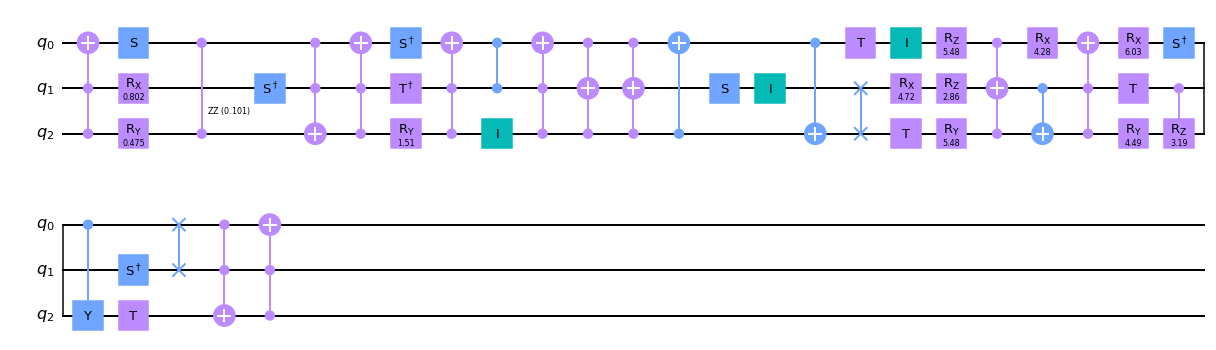

In [29]:
standard_rand_circ.draw(output = 'mpl')

In [30]:
first_half, second_half = general_error_mitigation_helper(standard_rand_circ)

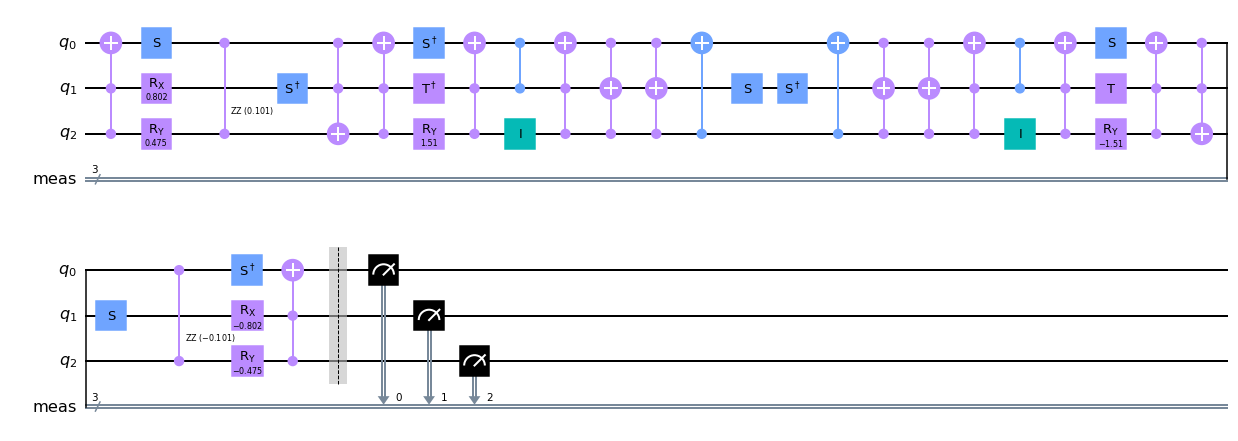

In [39]:
first_half[0].draw(output = 'mpl')

In [36]:
qc = standard_rand_circ
shots = 4096

In [37]:
calib_run_1 = [0] * 2 ** qn
calib_run_2 = [0] * 2 ** qn
calib_results_1 = [0] * 2 ** qn
calib_results_2 = [0] * 2 ** qn

start_time = time.time()
print("Start time for calibration matrices: ", time.ctime(start_time))
for i in range(2**(qn)):
        calib_run_1[i] = backend_qpu.run(first_half[i], shots=shots)
        calib_run_2[i] = backend_qpu.run(second_half[i], shots=shots)

end_time = time.time()
print("End time: ", time.ctime(end_time))

noisy_gem_run = backend_qpu.run(qc, shots=shots)

Start time for calibration matrices:  Tue Jul 19 11:00:13 2022
End time:  Tue Jul 19 11:00:18 2022


In [34]:
for i in range(2 ** qn):
    start_time = time.time()
    print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
    calib_results_1[i] = calib_run_1[i].result()
    end_time = time.time()
    print("End time for running calib circ", i, ": ", time.ctime(end_time))
    start_time = time.time()
    print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
    calib_results_2[i] = calib_run_2[i].result()
    end_time = time.time()
    print("End time for running calib circ", i, ": ", time.ctime(end_time))
    

noisy_gem = noisy_gem_run.result()

Start time for running calib circ 1. 0 :  Mon Jul 18 23:46:19 2022
End time for running calib circ 0 :  Mon Jul 18 23:49:31 2022
Start time for running calib circ 2. 0 :  Mon Jul 18 23:49:31 2022


KeyboardInterrupt: 

In [38]:
i = 0 
print("Start time for running calib circ 1.",i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

Start time for running calib circ 1. 0 :  Tue Jul 19 11:00:13 2022


KeyboardInterrupt: 

In [ ]:
i = 1
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
i =2 
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
i = 3
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
i = 4 
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
i = 5 
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
i = 6 
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
i = 7
print("Start time for running calib circ 1.", i, ": ",time.ctime(start_time))
calib_results_1[i] = calib_run_1[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))
start_time = time.time()
print("Start time for running calib circ 2.", i, ": ",time.ctime(start_time))
calib_results_2[i] = calib_run_2[i].result()
end_time = time.time()
print("End time for running calib circ", i, ": ", time.ctime(end_time))

In [ ]:
noisy_gem = noisy_gem_run.result()